In [2]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, mixture
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import h5py 

import sys
sys.path.append('../../')

from evaluation import *
np.random.seed(5)

/home/aryzhikov/.conda/envs/lasagne2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import pandas as pd
#! wget -o  ../../datasets/ https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
column_names = 'label, lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'.split(', ')
data = pd.read_csv('../../datasets/HIGGS.csv.gz', header=None, names=column_names)

In [4]:
X_data = np.array(data.drop('label', 1))
X_data = StandardScaler().fit_transform(X_data)

labels = np.array(data["label"])

In [5]:
from sklearn.model_selection import train_test_split
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), stratify=labels, test_size=0.1, random_state = 5)

In [6]:
y_train = labels[indx_train]
y_test = labels[indx_test]

X_train = X_data[indx_train]
X_test = X_data[indx_test]

In [7]:
X_good = X_train[np.where(y_train==0)[0]]

In [8]:
X_good.shape, X_train.shape, X_data.shape

((4653789, 28), (9900000, 28), (11000000, 28))

## One-Class NN

[Sources](https://github.com/raghavchalapathy/oc-nn)

[Paper](https://arxiv.org/pdf/1802.06360.pdf)

In [76]:
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import InputLayer, DenseLayer
from lasagne.nonlinearities import sigmoid, rectify
from lasagne.regularization import regularize_layer_params_weighted, l2

input_size = X_good.shape[1] # features cnt
output_size = 1
r = np.random.normal(0,1, (1,1))
r = lasagne.utils.create_param(r, (1,1))

input_var = T.matrix('input', dtype='float32')
lr_var = T.scalar('learning rate')
nu_var = T.scalar('nu') # 0.04

network = InputLayer(shape=(None, input_size), input_var=input_var)
V = DenseLayer(network, 64, nonlinearity=sigmoid)
w = DenseLayer(network, output_size)
output = lasagne.layers.get_output(w)

loss = regularize_layer_params_weighted({V: 0.5, w: 0.5}, l2) + (1./nu_var) * T.mean(rectify(r - output) - r)
params = lasagne.layers.get_all_params(w, trainable=True) + lasagne.utils.collect_shared_vars([r])
updates = lasagne.updates.rmsprop(loss, params, learning_rate=lr_var)

train_fn = theano.function([input_var, lr_var, nu_var], [output - r, loss], updates=updates, allow_input_downcast=True)
test_fn = theano.function([input_var], [output - r], allow_input_downcast=True)

In [87]:
BATCH_SIZE = 100000
N_EPOCHES = 1000
nu = 1.0
lr = 1e-3

for epoch in range(N_EPOCHES):
    for batch_id in range(int(round(1.0 * X_good.shape[0]/BATCH_SIZE))):
        batch_idx = range(BATCH_SIZE * batch_id, min(X_good.shape[0], BATCH_SIZE * (batch_id + 1)))
        _, loss = train_fn(X_good[batch_idx], lr, nu)
    print('Epoch: %d Loss: %f' % (epoch, loss))

Epoch: 0 Loss: -42.543222
Epoch: 1 Loss: -42.590194
Epoch: 2 Loss: -42.637166
Epoch: 3 Loss: -42.684139
Epoch: 4 Loss: -42.731111
Epoch: 5 Loss: -42.778082
Epoch: 6 Loss: -42.825055
Epoch: 7 Loss: -42.872027
Epoch: 8 Loss: -42.918998
Epoch: 9 Loss: -42.965972
Epoch: 10 Loss: -43.012943
Epoch: 11 Loss: -43.059914
Epoch: 12 Loss: -43.106888
Epoch: 13 Loss: -43.153860
Epoch: 14 Loss: -43.200832
Epoch: 15 Loss: -43.247804
Epoch: 16 Loss: -43.294775
Epoch: 17 Loss: -43.341747
Epoch: 18 Loss: -43.388720
Epoch: 19 Loss: -43.435692
Epoch: 20 Loss: -43.482665
Epoch: 21 Loss: -43.529636
Epoch: 22 Loss: -43.576609
Epoch: 23 Loss: -43.623580
Epoch: 24 Loss: -43.670551
Epoch: 25 Loss: -43.717525
Epoch: 26 Loss: -43.764496
Epoch: 27 Loss: -43.811469
Epoch: 28 Loss: -43.858440
Epoch: 29 Loss: -43.905413
Epoch: 30 Loss: -43.952383
Epoch: 31 Loss: -43.999355
Epoch: 32 Loss: -44.046329
Epoch: 33 Loss: -44.093301
Epoch: 34 Loss: -44.140272
Epoch: 35 Loss: -44.187246
Epoch: 36 Loss: -44.234218
Epoch: 37 L

Epoch: 297 Loss: -56.493957
Epoch: 298 Loss: -56.540928
Epoch: 299 Loss: -56.587900
Epoch: 300 Loss: -56.634872
Epoch: 301 Loss: -56.681845
Epoch: 302 Loss: -56.728818
Epoch: 303 Loss: -56.775790
Epoch: 304 Loss: -56.822761
Epoch: 305 Loss: -56.869733
Epoch: 306 Loss: -56.916706
Epoch: 307 Loss: -56.963679
Epoch: 308 Loss: -57.010652
Epoch: 309 Loss: -57.057623
Epoch: 310 Loss: -57.104596
Epoch: 311 Loss: -57.151567
Epoch: 312 Loss: -57.198540
Epoch: 313 Loss: -57.245512
Epoch: 314 Loss: -57.292484
Epoch: 315 Loss: -57.339456
Epoch: 316 Loss: -57.386429
Epoch: 317 Loss: -57.433402
Epoch: 318 Loss: -57.480374
Epoch: 319 Loss: -57.527347
Epoch: 320 Loss: -57.574318
Epoch: 321 Loss: -57.621290
Epoch: 322 Loss: -57.668262
Epoch: 323 Loss: -57.715234
Epoch: 324 Loss: -57.762206
Epoch: 325 Loss: -57.809179
Epoch: 326 Loss: -57.856151
Epoch: 327 Loss: -57.903124
Epoch: 328 Loss: -57.950097
Epoch: 329 Loss: -57.997068
Epoch: 330 Loss: -58.044040
Epoch: 331 Loss: -58.091013
Epoch: 332 Loss: -58

Epoch: 590 Loss: -70.256828
Epoch: 591 Loss: -70.303799
Epoch: 592 Loss: -70.350771
Epoch: 593 Loss: -70.397745
Epoch: 594 Loss: -70.444717
Epoch: 595 Loss: -70.491689
Epoch: 596 Loss: -70.538661
Epoch: 597 Loss: -70.585634
Epoch: 598 Loss: -70.632606
Epoch: 599 Loss: -70.679578
Epoch: 600 Loss: -70.726551
Epoch: 601 Loss: -70.773524
Epoch: 602 Loss: -70.820496
Epoch: 603 Loss: -70.867466
Epoch: 604 Loss: -70.914440
Epoch: 605 Loss: -70.961411
Epoch: 606 Loss: -71.008385
Epoch: 607 Loss: -71.055356
Epoch: 608 Loss: -71.102329
Epoch: 609 Loss: -71.149301
Epoch: 610 Loss: -71.196272
Epoch: 611 Loss: -71.243246
Epoch: 612 Loss: -71.290219
Epoch: 613 Loss: -71.337190
Epoch: 614 Loss: -71.384163
Epoch: 615 Loss: -71.431135
Epoch: 616 Loss: -71.478107
Epoch: 617 Loss: -71.525080
Epoch: 618 Loss: -71.572052
Epoch: 619 Loss: -71.619024
Epoch: 620 Loss: -71.665996
Epoch: 621 Loss: -71.712969
Epoch: 622 Loss: -71.759940
Epoch: 623 Loss: -71.806913
Epoch: 624 Loss: -71.853885
Epoch: 625 Loss: -71

Epoch: 883 Loss: -84.019724
Epoch: 884 Loss: -84.066696
Epoch: 885 Loss: -84.113669
Epoch: 886 Loss: -84.160641
Epoch: 887 Loss: -84.207614
Epoch: 888 Loss: -84.254585
Epoch: 889 Loss: -84.301557
Epoch: 890 Loss: -84.348530
Epoch: 891 Loss: -84.395504
Epoch: 892 Loss: -84.442475
Epoch: 893 Loss: -84.489447
Epoch: 894 Loss: -84.536420
Epoch: 895 Loss: -84.583391
Epoch: 896 Loss: -84.630365
Epoch: 897 Loss: -84.677337
Epoch: 898 Loss: -84.724309
Epoch: 899 Loss: -84.771281
Epoch: 900 Loss: -84.818254
Epoch: 901 Loss: -84.865227
Epoch: 902 Loss: -84.912199
Epoch: 903 Loss: -84.959171
Epoch: 904 Loss: -85.006144
Epoch: 905 Loss: -85.053116
Epoch: 906 Loss: -85.100088
Epoch: 907 Loss: -85.147060
Epoch: 908 Loss: -85.194033
Epoch: 909 Loss: -85.241006
Epoch: 910 Loss: -85.287978
Epoch: 911 Loss: -85.334951
Epoch: 912 Loss: -85.381923
Epoch: 913 Loss: -85.428895
Epoch: 914 Loss: -85.475868
Epoch: 915 Loss: -85.522839
Epoch: 916 Loss: -85.569812
Epoch: 917 Loss: -85.616784
Epoch: 918 Loss: -85

In [88]:
test_preds.min(), test_preds.max()

(-1.9354398378836848, 2.054615246344831)

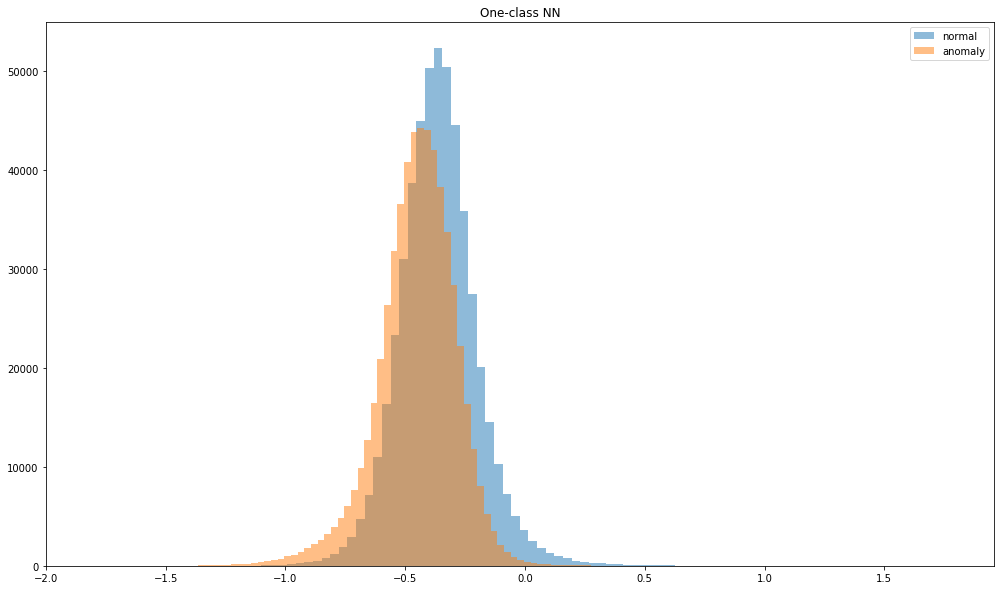

In [91]:
test_preds = test_fn(X_test)[0].squeeze()

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(17,10))
plt.title('One-class NN')
plt.hist(test_preds[np.argwhere(y_test == 0)], label='normal', alpha=0.5, bins=100)
plt.hist(test_preds[np.argwhere(y_test == 1)], label='anomaly', alpha=0.5, bins=100)
plt.legend()

One-class NN
('recall_score ', 0.9999982844751867)
('precision_score ', 0.5299359525075797)
('f1_score ', 0.6927553231757282)
confusion_matrix 
[[    34 517054]
 [     1 582911]]


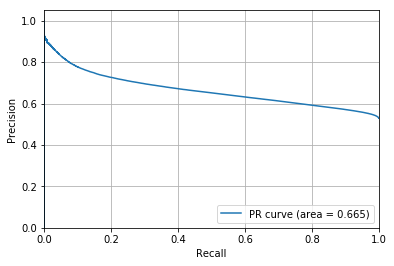

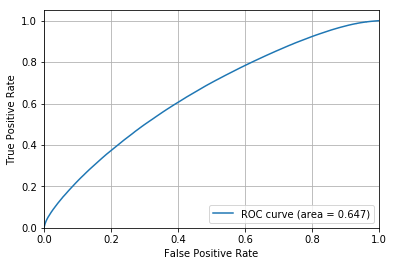

In [118]:
sigmoid = lambda x: 1./(1 + np.exp(-x))
y_test_rescale = np.where(y_test == 0, np.ones((y_test.shape)), -np.ones((y_test.shape)))
bound = 0.5 * (test_preds[np.argwhere(y_test == 0)].mean() + test_preds[np.argwhere(y_test == 1)].mean())
y_pred = sigmoid(test_fn(X_test) - bound).squeeze() - 0.5
        
print ('One-class NN')
print ("recall_score ",recall_score(-y_test_rescale, np.sign(-y_pred)))
print ("precision_score ",precision_score(-y_test_rescale, np.sign(-y_pred)))
print ("f1_score ",f1_score(-y_test_rescale, np.sign(-y_pred)))
print ("confusion_matrix ")
print (confusion_matrix(-y_test_rescale, np.sign(-y_pred)))



Score = y_pred + 0.5


precision, recall, _ = precision_recall_curve(-y_test_rescale, -Score)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label='PR curve (area = %0.3f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

fpr, tpr, _ = roc_curve(-y_test_rescale, -Score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

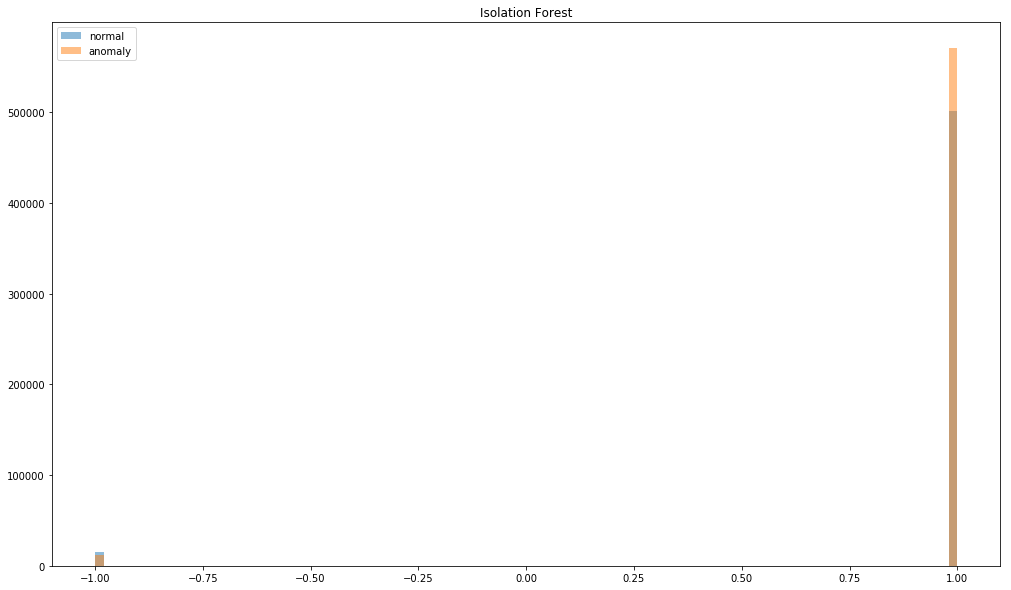

In [93]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=500, contamination=0.03, random_state=10)
clf.fit(X_good)

test_preds = clf.predict(X_test).squeeze()

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(17,10))
plt.title('Isolation Forest')
plt.hist(test_preds[np.argwhere(y_test == 0)], label='normal', alpha=0.5, bins=100)
plt.hist(test_preds[np.argwhere(y_test == 1)], label='anomaly', alpha=0.5, bins=100)
plt.legend()

Isolation forest
('recall_score ', 0.02122790404040404)
('precision_score ', 0.445364238410596)
('f1_score ', 0.04052425429346189)
confusion_matrix 
[[501678  15410]
 [570538  12374]]


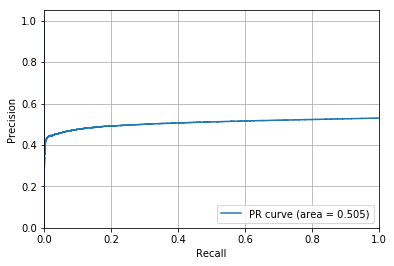

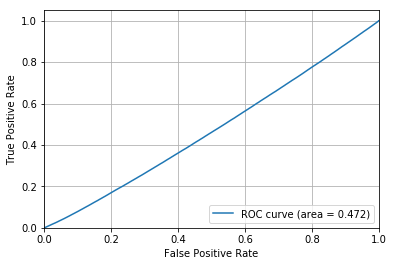

In [95]:
y_test_rescale = np.where(y_test == 0, np.ones((y_test.shape)), -np.ones((y_test.shape)))
y_pred = clf.predict(X_test)
        
print ('Isolation forest')
print ("recall_score ",recall_score(-y_test_rescale, np.round(-y_pred)))
print ("precision_score ",precision_score(-y_test_rescale, np.round(-y_pred)))
print ("f1_score ",f1_score(-y_test_rescale, np.round(-y_pred)))
print ("confusion_matrix ")
print (confusion_matrix(-y_test_rescale, np.round(-y_pred)))



Score = clf.decision_function(X_test)


precision, recall, _ = precision_recall_curve(-y_test_rescale, -Score)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label='PR curve (area = %0.3f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

fpr, tpr, _ = roc_curve(-y_test_rescale, -Score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()